### Ribosome ramp

Improved Ribosome-Footprint and mRNA Measurements Provide Insights into Dynamics and Regulation of Yeast Translation

http://www.cell.com/cell-reports/abstract/S2211-1247(16)30021-3

In [48]:
import cPickle as pkl
import numpy as np
import pandas as pd
import shelve
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use('ggplot')

In [6]:
filepath_general = "../results/updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2051_3600s.p"
filepath_polysomes = "../results/ribosome_timecourses_updated Shah transcriptome, full exome, no decay, updated initiation rates according to Shah_20151120_2052.db"

Regular results:

Make file readable by ipython in case it was created by pypy:

In [29]:
from tempfile import mkstemp
from shutil import move
from os import remove, close

def replace(file_path, pattern, subst):
    #Create temp file
    fh, abs_path = mkstemp()
    with open(abs_path, 'w') as new_file:
        with open(file_path) as old_file:
            for line in old_file:
                new_file.write(line.replace(pattern, subst))
    close(fh)
    #Remove original file
    remove(file_path)
    #Move new file
    move(abs_path, file_path)
    
# replace(filepath, "_numpypy.multiarray", "numpy.core.multiarray")

In [10]:
results = pkl.load(open(filepath_general))

In [11]:
print results.keys()

['n_tRNA', 'description', 'n_ribosomes', 'timerange', 'proteome', 'transcriptome', 'duration', 'time_stamp', 'timecourses']


Detailed results/ribosome timecourses:

In [7]:
d = shelve.open(filepath_polysomes)

Generate the ribosome lattice dict (for every gene the total of ribos at all positions):

In [13]:
ribo_lattice_dict = {}

for mRNA in results['transcriptome']:
    n_nucleotides = len(mRNA.sequence)
    last_polysome = d['mRNA_'+str(mRNA.index).zfill(5)][-1]  # we look at last polysome to catch steady state

    # Select only every third element (the others are zero anyway):
    # translate the model's polysome format to lattice of ones and zeros:
    ribos = np.array([1 if pos in last_polysome else 0 for pos in range(0, n_nucleotides, 3)])
    
    if mRNA.geneID in ribo_lattice_dict:  # if this gene has been encountered before
        ribo_lattice_dict[mRNA.geneID] += ribos
    else:                                 # if this gene is new
        ribo_lattice_dict[mRNA.geneID] = ribos

In [14]:
avg_ribos_per_gene = {}

for gene in ribo_lattice_dict:
    avg_ribos_per_gene[gene] = np.mean(ribo_lattice_dict[gene])

In [16]:
pd.Series(avg_ribos_per_gene).describe()

count    4475.000000
mean        0.120880
std         0.573657
min         0.000000
25%         0.007296
50%         0.018478
75%         0.053223
max        12.544326
dtype: float64

Check by means of an example:

In [28]:
print sum(ribo_lattice_dict['YIL140W'])*1.0/len(ribo_lattice_dict['YIL140W'])
print avg_ribos_per_gene['YIL140W']
print np.mean(ribo_lattice_dict['YIL140W'])

0.0109223300971
0.0109223300971
0.0109223300971


#### Analysis of all genes (no count restriction)

Define Weinberg's z (eq. S7):

In [32]:
z = {}

for gene in ribo_lattice_dict:
    if avg_ribos_per_gene[gene]>0:
        z[gene] = ribo_lattice_dict[gene] / avg_ribos_per_gene[gene]

Excess ribosome densities:

In [33]:
max_length = max([len(ribo_lattice_dict[gene]) for gene in ribo_lattice_dict])
print max_length

4911


In [50]:
import math

excess = []

for pos in range(max_length):
    numer = sum([z[gene][pos] for gene in z if len(ribo_lattice_dict[gene]) > pos])
    denom = sum([1.0          for gene in z if len(ribo_lattice_dict[gene]) > pos])
    excess.append(numer / denom)

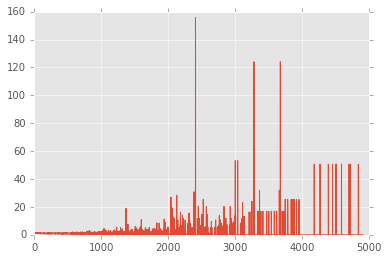

In [51]:
plt.plot(excess)